In [17]:
%pip install kagglehub matplotlib nltk numpy pandas seaborn torch scikit-learn ipywidgets sentence-transformers streamlit nbformat spacy textblob

try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    pass # Not running in Colab

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached spacy-3.8.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (27 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp310-cp310-macosx_11_0_arm64.whl.metadata (8.4 kB)
  Using cached preshed-3.0.9-cp310-cp310-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached thinc-8.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp310-cp310-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached blis-1.0.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.6 kB)
  Using cached confection-0.1.5-py3-no

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from ipywidgets import interact
import ipywidgets as widgets
import seaborn as sns

In [3]:
# Why Text Can't Be Input Directly
example_text = ["serendipity", "cascade", "ephemeral", "zenith", "labyrinth"]

# Try to perform mathematical operations directly on text
try:
    result = example_text[0] + example_text[1]
    print(f"Adding words: {example_text[0]} + {example_text[1]} = {result}")
except TypeError as e:
    print(f"Error: {e}")
    
print("""
Why this doesn't work? 

1. Text is categorical, not numerical
2. No mathematical structure
3. Models require inputs for computation
""")


# Show what happens when trying to find similarity
print("\nTrying to measure word similarity:")
print(f"Words: '{example_text[0]}' and '{example_text[1]}'")
print("Direct comparison only shows if they're exactly equal:")
print(f"Are they equal? {example_text[0] == example_text[1]}")
print("But we can't measure HOW similar they are!")

# Demonstrate array operations failing
print("\nTrying to use in numpy array operations:")
try:
    word_array = np.array(example_text)
    result = word_array * 2
    print(result)
except TypeError as e:
    print(f"Error: {e}")


Adding words: serendipity + cascade = serendipitycascade

Why this doesn't work? 

1. Text is categorical, not numerical
2. No mathematical structure
3. Models require inputs for computation


Trying to measure word similarity:
Words: 'serendipity' and 'cascade'
Direct comparison only shows if they're exactly equal:
Are they equal? False
But we can't measure HOW similar they are!

Trying to use in numpy array operations:
Error: The 'out' kwarg is necessary. Use numpy.strings.multiply without it.


In [4]:
# Cell 2: Naive Approach - Word to Number Mapping
word_to_num = {
    "hello": 1,
    "hi": 2,
    "hey": 3, 
    "howdy": 4,
    "greetings": 5,
    "welcome": 6,
    "tree": 7,
    "flower": 8,
    "mountain": 9,
    "river": 10,
    "ocean": 11,
    "forest": 12
}

def is_greeting(word_num):
    return word_num in [1, 2, 3, 4, 5, 6]

def is_nature(word_num):
    return word_num in [7, 8, 9, 10, 11, 12]

def simple_classifier(word_num):
    # Simulate a simple model that classifies words
    return "greeting" if is_greeting(word_num) else "nature" if is_nature(word_num) else "unknown"

# Test the classifier
test_words = ["hello", "howdy", "tree", "ocean"]
print("Testing our simple number mapping:")
for word in test_words:
    num = word_to_num[word]
    classification = simple_classifier(num)
    print(f"{word} (number {num}) -> {classification}")

# Try with an unknown word
print("""
Trying with a new word:
'Yo!' -> ???  # 13th most common greeting? https://tandem.net/blog/20-greetings-in-english
Problem: Our system breaks with unknown words!
""")



Testing our simple number mapping:
hello (number 1) -> greeting
howdy (number 4) -> greeting
tree (number 7) -> nature
ocean (number 11) -> nature

Trying with a new word:
'Yo!' -> ???  # 13th most common greeting? https://tandem.net/blog/20-greetings-in-english
Problem: Our system breaks with unknown words!



In [5]:

print("""
Problems with simple number mapping:
1. No relationship between similar words
   - 'hello' (1) and 'hi' (3) are similar but their numbers aren't
2. No context preservation
3. Can't handle new words
4. Arbitrary number assignment
""")




Problems with simple number mapping:
1. No relationship between similar words
   - 'hello' (1) and 'hi' (3) are similar but their numbers aren't
2. No context preservation
3. Can't handle new words
4. Arbitrary number assignment



In [6]:

# Cell 4: Introduction to Word Embeddings
# Create some simple 2D embeddings for demonstration
simple_embeddings = {
    "hello":     [0.8, 0.9],
    "hi":        [0.7, 0.8], 
    "hey":       [0.75, 0.85],
    "greetings": [0.9, 0.7],
    "howdy":     [0.85, 0.75],
    "world":     [-0.5, 0.5],
    "earth":     [-0.6, 0.4],
    "planet":    [-0.4, 0.6],
    "tree":      [-0.8, -0.3],
    "forest":    [-0.9, -0.4], 
    "ocean":     [-0.7, -0.5],
    "yo":        [0.65, 0.85],
}

def plot_embeddings(highlight_word=None):
    plt.figure(figsize=(10, 6))
    for word, coords in simple_embeddings.items():
        if word == highlight_word:
            plt.scatter(coords[0], coords[1], c='red', s=100)
            plt.annotate(word, (coords[0], coords[1]), fontsize=12, color='red')
        else:
            plt.scatter(coords[0], coords[1])
            plt.annotate(word, (coords[0], coords[1]), fontsize=10)
    
    plt.title("Simple 2D Word Embeddings")
    plt.grid(True)
    plt.show()

# Interactive widget to highlight words
interact(plot_embeddings, 
        highlight_word=widgets.Dropdown(
            options=[''] + list(simple_embeddings.keys()),
            description='Highlight:',
            value=''
        ))



interactive(children=(Dropdown(description='Highlight:', options=('', 'hello', 'hi', 'hey', 'greetings', 'howd…

<function __main__.plot_embeddings(highlight_word=None)>

In [7]:
# Cell 5: Similarity in Embedding Space
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def find_similar_words(word, n=3):
    if word not in simple_embeddings:
        return "Word not found in vocabulary"
    
    similarities = {}
    word_embedding = simple_embeddings[word]
    
    for other_word, other_embedding in simple_embeddings.items():
        if other_word != word:
            similarity = cosine_similarity(word_embedding, other_embedding)
            similarities[other_word] = similarity
    
    # Sort by similarity
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:n]

# Interactive similarity finder
def show_similarities(word):
    similar_words = find_similar_words(word)
    print(f"\nMost similar words to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity:.3f}")
    
    # Also show the plot with the word highlighted
    plot_embeddings(word)

interact(show_similarities, 
        word=widgets.Dropdown(
            options=list(simple_embeddings.keys()),
            description='Word:',
            value='hello'
        ))



interactive(children=(Dropdown(description='Word:', options=('hello', 'hi', 'hey', 'greetings', 'howdy', 'worl…

<function __main__.show_similarities(word)>

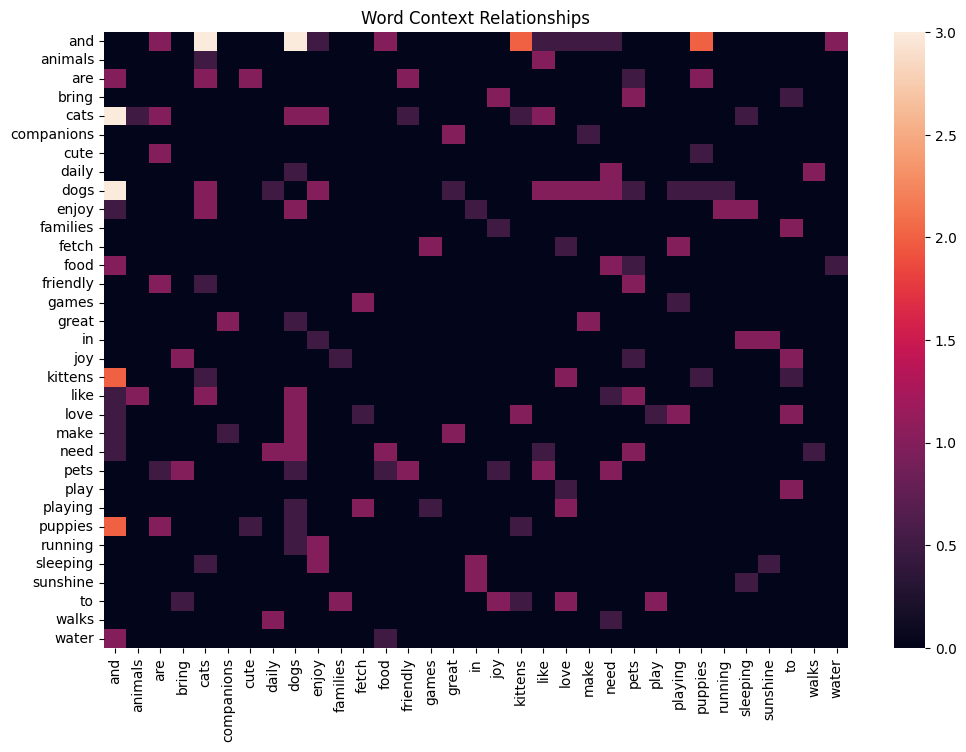

interactive(children=(Dropdown(description='Word:', index=8, options=('and', 'animals', 'are', 'bring', 'cats'…


Key Concepts:
1. Words are represented by their contexts (surrounding words)
2. Similar words appear in similar contexts
3. Position and distance between words matters
4. This creates meaningful semantic relationships
5. Modern embeddings use similar principles but with neural networks



In [8]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

corpus = [
    "dogs and cats are friendly pets",
    "pets like dogs need daily walks",
    "cats and kittens love to play",
    "puppies and dogs enjoy running",
    "pets bring joy to families",
    "cats enjoy sleeping in sunshine", 
    "dogs love playing fetch games",
    "kittens and puppies are cute",
    "pets need food and water",
    "animals like cats and dogs make great companions"
]

def create_context_matrix(corpus, window_size=2):
    # Create vocabulary 
    words = ' '.join(corpus).split()
    vocab = sorted(list(set(words)))
    word_to_idx = {word: i for i, word in enumerate(vocab)}
    
    # Initialize context matrix
    context_matrix = np.zeros((len(vocab), len(vocab)))
    
    # Count word co-occurrences with position weighting
    for sentence in corpus:
        words = sentence.split()
        for i, word in enumerate(words):
            # Look at surrounding context words
            start = max(0, i - window_size)
            end = min(len(words), i + window_size + 1)
            
            for j in range(start, end):
                if i != j:
                    # Weight by distance - closer words matter more
                    distance = abs(i - j)
                    weight = 1.0 / distance
                    context_matrix[word_to_idx[word]][word_to_idx[words[j]]] += weight
    
    return context_matrix, vocab

def get_similar_words(word, context_matrix, vocab, n=5):
    if word not in vocab:
        return []
    
    word_idx = vocab.index(word)
    word_vector = context_matrix[word_idx]
    
    # Calculate cosine similarities
    similarities = []
    for i, other_word in enumerate(vocab):
        if i != word_idx:
            other_vector = context_matrix[i]
            similarity = np.dot(word_vector, other_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(other_vector))
            similarities.append((other_word, similarity))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n]

def plot_word_similarities(word, context_matrix, vocab):
    similar_words = get_similar_words(word, context_matrix, vocab)
    if not similar_words:
        print(f"Word '{word}' not found in vocabulary")
        return
        
    words, scores = zip(*similar_words)
    
    plt.figure(figsize=(10, 4))
    plt.barh(words, scores)
    plt.title(f"Words most semantically similar to '{word}'")
    plt.xlabel("Similarity score")
    plt.show()

# Create and display context matrix
context_matrix, vocab = create_context_matrix(corpus)

# Show heatmap of relationships
plt.figure(figsize=(12, 8))
sns.heatmap(context_matrix, xticklabels=vocab, yticklabels=vocab)
plt.title("Word Context Relationships")
plt.show()

# Interactive widget to explore semantic similarities
interact(
    lambda word: plot_word_similarities(word, context_matrix, vocab),
    word=widgets.Dropdown(
        options=vocab,
        description='Word:',
        value='dogs'
    )
)

print("""
Key Concepts:
1. Words are represented by their contexts (surrounding words)
2. Similar words appear in similar contexts
3. Position and distance between words matters
4. This creates meaningful semantic relationships
5. Modern embeddings use similar principles but with neural networks
""")

In [9]:
# Import required libraries
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
import plotly.express as px
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

# Initialize the embedding model
def load_model():
    return SentenceTransformer('all-MiniLM-L6-v2')

# Function to get embeddings and reduce dimensionality
def get_3d_embeddings(texts, model):
    # Get embeddings
    embeddings = model.encode(texts)

    # print the shape of the embeddings
    print(embeddings.shape)
    
    # Reduce to 3D using PCA
    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(embeddings)
    
    return embeddings_3d

# Function to find similar texts
def find_similar_texts(search_text, texts, model, n=5):
    # Encode search text and all texts
    all_texts = [search_text] + texts
    all_embeddings = model.encode(all_texts)
    
    search_embedding = all_embeddings[0]
    text_embeddings = all_embeddings[1:]
    
    similarities = []
    for i, embedding in enumerate(text_embeddings):
        similarity = np.dot(search_embedding, embedding) / (np.linalg.norm(search_embedding) * np.linalg.norm(embedding))
        similarities.append((texts[i], similarity))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:n]

# Initial example texts
default_texts = [
    "hello", "hi", "hey", "greetings", 
    "world", "earth", "planet",
    "tree", "forest", "ocean"
]

# Load model
model = load_model()

# Create widgets
text_input = widgets.Text(description='Add text:', placeholder='Enter text here')
search_input = widgets.Text(description='Search:', placeholder='Search similar texts')
add_button = widgets.Button(description='Add')
search_button = widgets.Button(description='Search')

# Create output widget for displaying results
plot_output = widgets.Output()
search_output = widgets.Output()

# Current texts list
texts = default_texts.copy()

def update_plot():
    with plot_output:
        clear_output(wait=True)
        
        # Get 3D embeddings
        embeddings_3d = get_3d_embeddings(texts, model)

        # Create DataFrame for plotting
        df = pd.DataFrame({
            'text': texts,
            'x': embeddings_3d[:, 0],
            'y': embeddings_3d[:, 1],
            'z': embeddings_3d[:, 2]
        })

        # Create 3D scatter plot
        fig = px.scatter_3d(
            df,
            x='x',
            y='y',
            z='z',
            text='text',
            title='3D Text Embeddings'
        )

        # Update layout for better visualization
        fig.update_traces(
            marker=dict(size=8),
            textposition='top center'
        )

        display(fig)

def on_add_button_clicked(b):
    if text_input.value and text_input.value not in texts:
        texts.append(text_input.value)
        text_input.value = ''
        update_plot()
        with search_output:
            clear_output()

def on_search_button_clicked(b):
    with search_output:
        clear_output()
        if search_input.value:
            similar = find_similar_texts(search_input.value, texts, model)
            print("\nMost similar texts to '{}':".format(search_input.value))
            for text, similarity in similar:
                print(f"{text}: {similarity:.3f}")

# Connect button clicks to handlers
add_button.on_click(on_add_button_clicked)
search_button.on_click(on_search_button_clicked)

# Display widgets and initial plot
display(widgets.HBox([text_input, add_button]))
display(widgets.HBox([search_input, search_button]))
display(plot_output)
display(search_output)

# Show initial plot
update_plot()


Output()

Output()

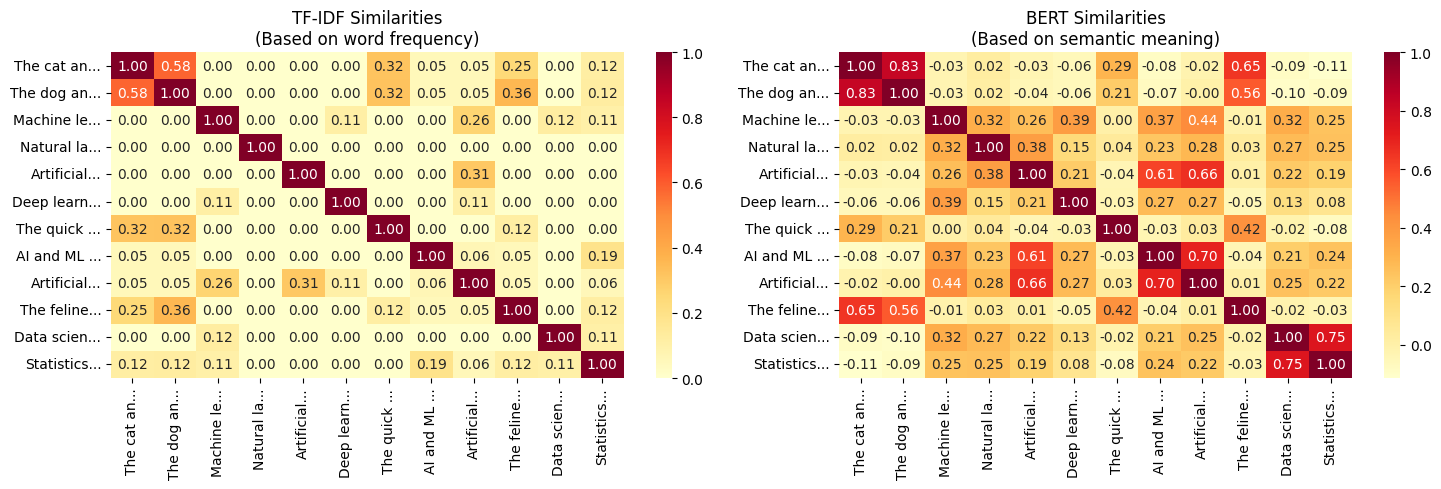


Key Differences Analysis:

1. TF-IDF vs BERT comparison:

Documents with different similarity scores:
Doc 1: The cat and dog played together in the yard
Doc 2: The feline and canine were engaging in recreational activities
TF-IDF similarity: 0.245
BERT similarity: 0.649

Documents with different similarity scores:
Doc 3: Machine learning algorithms process data efficiently
Doc 4: Natural language processing helps computers understand text
TF-IDF similarity: 0.000
BERT similarity: 0.319

Documents with different similarity scores:
Doc 3: Machine learning algorithms process data efficiently
Doc 4: AI and ML are revolutionizing industries
TF-IDF similarity: 0.000
BERT similarity: 0.368

Documents with different similarity scores:
Doc 4: Natural language processing helps computers understand text
Doc 5: Artificial intelligence is transforming technology
TF-IDF similarity: 0.000
BERT similarity: 0.378

Documents with different similarity scores:
Doc 5: Artificial intelligence is transformi

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example corpus with diverse examples
corpus = [
    "The cat and dog played together in the yard",
    "The dog and cat were playing in the garden",  # Similar meaning but different words
    "Machine learning algorithms process data efficiently",
    "Natural language processing helps computers understand text",
    "Artificial intelligence is transforming technology",
    "Deep learning models require large datasets",
    "The quick brown fox jumps over the lazy dog",  # Common test sentence
    "AI and ML are revolutionizing industries",  # Abbreviations vs full words
    "Artificial intelligence and machine learning transform businesses",  # Same meaning as above
    "The feline and canine were engaging in recreational activities",  # Formal version of first sentence
    "Data science uses statistical methods",
    "Statistics and mathematics are used in data analysis"  # Similar topic, different words
]

def compare_embeddings(corpus):
    # TF-IDF Embeddings with smoothing to prevent divide by zero
    tfidf = TfidfVectorizer(smooth_idf=True)  # Add smoothing
    tfidf_embeddings = tfidf.fit_transform(corpus).toarray()
    
    # BERT Embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')
    bert_embeddings = model.encode(corpus)
    
    # Calculate similarity matrices with error handling
    def cosine_similarity_matrix(embeddings):
        # Add small epsilon to prevent division by zero
        epsilon = 1e-8
        norm = np.linalg.norm(embeddings, axis=1)
        norm = np.maximum(norm, epsilon)  # Ensure no zeros in denominator
        normalized = embeddings / norm[:, np.newaxis]
        return normalized @ normalized.T
    
    tfidf_sim = cosine_similarity_matrix(tfidf_embeddings)
    bert_sim = cosine_similarity_matrix(bert_embeddings)
    
    # Visualize similarities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    labels = [text[:10]+'...' for text in corpus]

    sns.heatmap(tfidf_sim, ax=ax1, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels)
    ax1.set_title('TF-IDF Similarities\n(Based on word frequency)')
    
    sns.heatmap(bert_sim, ax=ax2, annot=True, fmt='.2f', cmap='YlOrRd',
                xticklabels=labels, yticklabels=labels)
    ax2.set_title('BERT Similarities\n(Based on semantic meaning)')
    
    plt.tight_layout()
    plt.show()
    
    # Print key differences analysis
    print("\nKey Differences Analysis:")
    print("\n1. TF-IDF vs BERT comparison:")
    for i in range(len(corpus)):
        for j in range(i+1, len(corpus)):
            diff = abs(bert_sim[i,j] - tfidf_sim[i,j])
            if diff > 0.3:  # Only show significant differences
                print(f"\nDocuments with different similarity scores:")
                print(f"Doc {i+1}: {corpus[i]}")
                print(f"Doc {i+2}: {corpus[j]}")
                print(f"TF-IDF similarity: {tfidf_sim[i,j]:.3f}")
                print(f"BERT similarity: {bert_sim[i,j]:.3f}")
    
    return tfidf_embeddings, bert_embeddings

# Interactive widget to add new sentences
def update_corpus(text_widget, _):
    new_sentence = text_widget.value
    if new_sentence and new_sentence not in corpus:
        corpus.append(new_sentence)
        compare_embeddings(corpus)
        print("\nKey Differences between TF-IDF and BERT:")
        print("1. TF-IDF captures word frequency patterns")
        print("2. BERT captures semantic relationships") 
        print("3. BERT understands word context and order")
        print("4. TF-IDF is simpler but misses semantic nuances")
        print("\nExample: 'AI' and 'artificial intelligence' would be:")
        print("- Different in TF-IDF (different words)")
        print("- Similar in BERT (same meaning)")
        text_widget.value = ''  # Clear the input after adding

text_input = widgets.Text(
    value='',
    placeholder='Enter a new sentence to compare...',
    description='Add Text:',
    style={'description_width': 'initial'}
)

add_button = widgets.Button(description='Add')
add_button.on_click(lambda b: update_corpus(text_input, b))

display(widgets.HBox([text_input, add_button]))

# Show initial comparison
compare_embeddings(corpus)

print("""
Key Observations:

1. TF-IDF Embeddings:
   - Based on word frequency statistics
   - Ignores word order and context
   - Treats similar words as different ('AI' vs 'artificial intelligence')
   - Fast and memory-efficient
   - Good for keyword extraction and basic document similarity
   
2. BERT Embeddings:
   - Captures contextual meaning
   - Understands semantic relationships
   - Recognizes similar concepts even with different words
   - More computationally intensive
   - Better for understanding language nuances
   
3. When to Use Each:
   - TF-IDF: Simple document classification, keyword extraction, search
   - BERT: Complex language understanding, semantic similarity, when context matters
""")

In [20]:

# Use spaCy for embeddings and TextBlob for sentiment - lightweight and stable
import spacy
from textblob import TextBlob
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Install spaCy and download the small English model
!python -m spacy download en_core_web_sm

# Load small English model
nlp = spacy.load('en_core_web_sm')

def get_embedding(text):
    # Get document vector using spaCy
    doc = nlp(text)
    return doc.vector

def get_sentiment(text):
    # Get sentiment polarity using TextBlob (-1 to 1)
    blob = TextBlob(text)
    return blob.sentiment.polarity

def analyze_text(text_input, output_widget):
    text = text_input.value
    if not text:
        return
        
    # Get embedding and sentiment
    embedding = get_embedding(text)

    # the embed
    sentiment = get_sentiment(text)
    
    # Clear previous output
    output_widget.clear_output()
    
    with output_widget:
        print(f"\nAnalysis for: '{text}'")
        print(f"Sentiment score: {sentiment:.2f}")
        if sentiment > 0:
            print("This text appears positive")
        elif sentiment < 0:
            print("This text appears negative") 
        else:
            print("This text appears neutral")
            
        print("\nText embedding (first 5 dimensions):")
        print(embedding[:5])

# Create widgets
text_input = widgets.Text(
    value='',
    placeholder='Enter text to analyze...',
    description='Text:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

analyze_button = widgets.Button(description='Analyze')
output = widgets.Output()

# Wire up the button click
analyze_button.on_click(lambda b: analyze_text(text_input, output))

# Display widgets
display(widgets.VBox([
    widgets.HBox([text_input, analyze_button]),
    output
]))

print("""
Try entering different texts to see:
1. The sentiment score (-1 to 1)
2. A sample of the text embedding vector

Example texts to try:
- I love this amazing product!
- This is the worst experience ever.
- The sky is blue.
""")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



Try entering different texts to see:
1. The sentiment score (-1 to 1)
2. A sample of the text embedding vector

Example texts to try:
- I love this amazing product!
- This is the worst experience ever.
- The sky is blue.

